In [36]:
import tensorflow as tf
import numpy as np
from finta import TA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import minmax_scale, normalize
import sys
import glob
import pylab
import numpy as np
from tensorflow.keras.layers import *
from tensorflow.keras.activations import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from keras_metrics import recall, precision

In [2]:
WINDOW_SIZE = 40
TRAIN_TEST_SPLIT = 0.98 # set to 0.1 for other stocks data testing

def preprocess(fname):
    df = pd.read_csv(fname)
    if '<DATE>' in df: df.pop('<DATE>')
    if '<TIME>' in df: df.pop('<TIME>')
    
    df.columns = ['open', 'high', 'low', 'close', 'volume']
    #dfcopy = df.copy()
    indicators = df.copy()
    indicators['KAMA'] = TA.KAMA(df)
    #indicators['HMA'] = TA.HMA(df)
    indicators['TEMA5'] = TA.TEMA(df, period=5)
    #indicators['TEMA20'] = TA.TEMA(df, period=20)
    #indicators['EMA25'] = TA.EMA(df, period=25)
    indicators['EMA40'] = TA.EMA(df, period=40)
    indicators['BBWIDTH'] = TA.BBWIDTH(df)
    #indicators['AO'] = TA.AO(df)
    indicators['RSI14'] = TA.RSI(df)
    #indicators['RSI8'] = TA.RSI(df, period=8)
    #indicators['RSI21'] = TA.RSI(df, period=21)
    #indicators['STC'] = TA.STC(df)
    #indicators['ATR'] = TA.ATR(df)
    #indicators = indicators.assign(**TA.EBBP(df))
    indicators = indicators.assign(**TA.KST(df))
    #indicators = indicators.assign(**TA.EV_MACD(df))
    indicators.dropna(inplace=True)
    
    dft = indicators.close - indicators.close.shift()
    dft.fillna(0, inplace=True)
    dft = dft.values
    signals = np.array([1 if i > 0 else 0 for i in dft])[:]
    dfcopy = indicators.close.values.copy()
    
    for k in ['open', 'high', 'low', 'close', 'volume']: indicators.pop(k)
    dfcopy = np.array([dfcopy[i+WINDOW_SIZE] for i in range(len(signals)-WINDOW_SIZE)])
    data = np.array([
        normalize(indicators[i:i+WINDOW_SIZE].values, axis=0, norm='max')
        for i in range(len(indicators)-WINDOW_SIZE)])
    signals = np.array([signals[i+WINDOW_SIZE] for i in range(len(signals)-WINDOW_SIZE)])
    
    split_index = int(len(data)*TRAIN_TEST_SPLIT)
    data_train, signals_train = data[:split_index], signals[:split_index]
    data_test, signals_test, dfcopy = data[split_index:], signals[split_index:], dfcopy[split_index:]
    return data_train, signals_train, data_test, signals_test, dfcopy

data_train, signals_train, data_test, signals_test, dfcopy = preprocess("./quotes/sbrf7.csv")

In [168]:
def preprocess(fname):
    df = pd.read_csv(fname)
    if '<DATE>' in df: df.pop('<DATE>')
    if '<TIME>' in df: df.pop('<TIME>')
    df.columns = ['open', 'high', 'low', 'close', 'volume']
    signals = np.array(df["close"] - df["close"].shift() > 0).astype(int)[1:]
    df = df[:-1]
    return signals[-10:], np.array(df.close[-10:])
    

In [169]:
preprocess("./quotes/sbrf8.csv")

(array([1, 0, 1, 0, 1, 1, 0, 1, 0, 1]),
 array([17440., 18075., 17354., 17680., 16527., 17024., 17044., 16969.,
        19139., 18901.]))

In [116]:
data = pd.read_csv("./quotes/sbrf8.csv")

In [120]:
data.shift()

,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20051010.0,0.0,27200.0,27250.0,27200.0,27250.0,2.0
2,20051013.0,0.0,26127.0,26127.0,25509.0,25509.0,3.0
3,20051014.0,0.0,24555.0,25585.0,24305.0,24800.0,74.0
4,20051017.0,0.0,25210.0,26900.0,24205.0,24984.0,51.0
...,...,...,...,...,...,...,...
3599,20200330.0,0.0,16493.0,17028.0,16037.0,17024.0,514807.0
3600,20200331.0,0.0,17028.0,17423.0,16933.0,17044.0,422302.0
3601,20200401.0,0.0,17042.0,17089.0,16724.0,16969.0,292031.0
3602,20200402.0,0.0,16977.0,19188.0,16763.0,19139.0,621840.0


In [4]:
model = tf.keras.models.load_model("./models/hours.h5")

W0408 21:58:54.586841 31072 deprecation.py:506] From C:\Users\Admin\.conda\envs\neuro\lib\site-packages\tensorflow\python\ops\init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0408 21:58:54.587838 31072 deprecation.py:506] From C:\Users\Admin\.conda\envs\neuro\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0408 21:58:54.589834 31072 deprecation.py:506] From C:\Users\Admin\.conda\envs\neuro\lib\site-packages\tensorflow\python\ops\init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) wit

In [11]:
model.fit(data_train, signals_train, shuffle=False, epochs=610, validation_data=(data_test, signals_test))

Train on 45341 samples, validate on 926 samples
Epoch 1/610
45341/45341 [==============================] - 38s 838us/sample - loss: 0.6763 - acc: 0.5683 - val_loss: 0.7029 - val_acc: 0.4989
Epoch 2/610
45341/45341 [==============================] - 41s 897us/sample - loss: 0.6753 - acc: 0.5719 - val_loss: 0.6980 - val_acc: 0.5011
Epoch 3/610
45341/45341 [==============================] - 39s 866us/sample - loss: 0.6745 - acc: 0.5733 - val_loss: 0.6961 - val_acc: 0.4968
Epoch 4/610
45341/45341 [==============================] - 40s 875us/sample - loss: 0.6747 - acc: 0.5770 - val_loss: 0.6962 - val_acc: 0.5032
Epoch 5/610
45341/45341 [==============================] - 32s 714us/sample - loss: 0.6745 - acc: 0.5761 - val_loss: 0.6977 - val_acc: 0.4957
Epoch 6/610
45341/45341 [==============================] - 45s 982us/sample - loss: 0.6749 - acc: 0.5740 - val_loss: 0.6970 - val_acc: 0.4914
Epoch 7/610
45341/45341 [==============================] - 35s 774us/sample - loss: 0.6750 - acc: 0.

45341/45341 [==============================] - 26s 568us/sample - loss: 0.6749 - acc: 0.5757 - val_loss: 0.6989 - val_acc: 0.5032
Epoch 58/610
45341/45341 [==============================] - 26s 564us/sample - loss: 0.6741 - acc: 0.5762 - val_loss: 0.6950 - val_acc: 0.5011
Epoch 59/610
45341/45341 [==============================] - 26s 567us/sample - loss: 0.6737 - acc: 0.5771 - val_loss: 0.6989 - val_acc: 0.5011
Epoch 60/610
45341/45341 [==============================] - 26s 566us/sample - loss: 0.6749 - acc: 0.5737 - val_loss: 0.6978 - val_acc: 0.4946
Epoch 61/610
45341/45341 [==============================] - 26s 576us/sample - loss: 0.6754 - acc: 0.5714 - val_loss: 0.6935 - val_acc: 0.5065
Epoch 62/610
45341/45341 [==============================] - 26s 570us/sample - loss: 0.6745 - acc: 0.5746 - val_loss: 0.6975 - val_acc: 0.5011
Epoch 63/610
45341/45341 [==============================] - 26s 569us/sample - loss: 0.6740 - acc: 0.5769 - val_loss: 0.6959 - val_acc: 0.4978
Epoch 64/610

45341/45341 [==============================] - 27s 587us/sample - loss: 0.6736 - acc: 0.5770 - val_loss: 0.6950 - val_acc: 0.5000
Epoch 115/610
45341/45341 [==============================] - 27s 587us/sample - loss: 0.6733 - acc: 0.5771 - val_loss: 0.6978 - val_acc: 0.4903
Epoch 116/610
45341/45341 [==============================] - 27s 591us/sample - loss: 0.6731 - acc: 0.5782 - val_loss: 0.7010 - val_acc: 0.4914
Epoch 117/610
45341/45341 [==============================] - 27s 592us/sample - loss: 0.6736 - acc: 0.5765 - val_loss: 0.6944 - val_acc: 0.4914
Epoch 118/610
45341/45341 [==============================] - 27s 587us/sample - loss: 0.6744 - acc: 0.5766 - val_loss: 0.6942 - val_acc: 0.5086
Epoch 119/610
45341/45341 [==============================] - 27s 591us/sample - loss: 0.6748 - acc: 0.5765 - val_loss: 0.6938 - val_acc: 0.5000
Epoch 120/610
45341/45341 [==============================] - 27s 593us/sample - loss: 0.6749 - acc: 0.5771 - val_loss: 0.6924 - val_acc: 0.4989
Epoch 

Epoch 171/610
45341/45341 [==============================] - 29s 629us/sample - loss: 0.6735 - acc: 0.5768 - val_loss: 0.6955 - val_acc: 0.5011
Epoch 172/610
45341/45341 [==============================] - 29s 637us/sample - loss: 0.6741 - acc: 0.5755 - val_loss: 0.6979 - val_acc: 0.4946
Epoch 173/610
45341/45341 [==============================] - 29s 641us/sample - loss: 0.6732 - acc: 0.5778 - val_loss: 0.6963 - val_acc: 0.4957
Epoch 174/610
45341/45341 [==============================] - 29s 645us/sample - loss: 0.6732 - acc: 0.5773 - val_loss: 0.6946 - val_acc: 0.4946ETA: 1s - loss: 0.6730 - acc: 0.5 - ETA: 0s - loss: 0.67
Epoch 175/610
45341/45341 [==============================] - 29s 634us/sample - loss: 0.6741 - acc: 0.5764 - val_loss: 0.6966 - val_acc: 0.4957
Epoch 176/610
45341/45341 [==============================] - 29s 633us/sample - loss: 0.6731 - acc: 0.5779 - val_loss: 0.6964 - val_acc: 0.4978
Epoch 177/610
45341/45341 [==============================] - 29s 637us/sample - 

45341/45341 [==============================] - 26s 572us/sample - loss: 0.6731 - acc: 0.5802 - val_loss: 0.6975 - val_acc: 0.4968
Epoch 228/610
45341/45341 [==============================] - 26s 565us/sample - loss: 0.6730 - acc: 0.5768 - val_loss: 0.6959 - val_acc: 0.4957
Epoch 229/610
45341/45341 [==============================] - 26s 569us/sample - loss: 0.6728 - acc: 0.5788 - val_loss: 0.6940 - val_acc: 0.5054
Epoch 230/610
45341/45341 [==============================] - 26s 568us/sample - loss: 0.6737 - acc: 0.5762 - val_loss: 0.6957 - val_acc: 0.4968
Epoch 231/610
45341/45341 [==============================] - 26s 568us/sample - loss: 0.6731 - acc: 0.5770 - val_loss: 0.6958 - val_acc: 0.4957
Epoch 232/610
45341/45341 [==============================] - 26s 574us/sample - loss: 0.6733 - acc: 0.5765 - val_loss: 0.7026 - val_acc: 0.4924
Epoch 233/610
45341/45341 [==============================] - 26s 576us/sample - loss: 0.6727 - acc: 0.5783 - val_loss: 0.6914 - val_acc: 0.5162
Epoch 

Epoch 284/610
45341/45341 [==============================] - 26s 570us/sample - loss: 0.6735 - acc: 0.5780 - val_loss: 0.6924 - val_acc: 0.4957
Epoch 285/610
45341/45341 [==============================] - 26s 565us/sample - loss: 0.6735 - acc: 0.5790 - val_loss: 0.6933 - val_acc: 0.5032
Epoch 286/610
45341/45341 [==============================] - 26s 569us/sample - loss: 0.6722 - acc: 0.5793 - val_loss: 0.6952 - val_acc: 0.4978
Epoch 287/610
45341/45341 [==============================] - 26s 573us/sample - loss: 0.6733 - acc: 0.5773 - val_loss: 0.6935 - val_acc: 0.4957
Epoch 288/610
45341/45341 [==============================] - 26s 569us/sample - loss: 0.6717 - acc: 0.5797 - val_loss: 0.7029 - val_acc: 0.4946
Epoch 289/610
45341/45341 [==============================] - 26s 570us/sample - loss: 0.6721 - acc: 0.5789 - val_loss: 0.6936 - val_acc: 0.5000
Epoch 290/610
45341/45341 [==============================] - 26s 584us/sample - loss: 0.6730 - acc: 0.5800 - val_loss: 0.6918 - val_acc:

45341/45341 [==============================] - 26s 570us/sample - loss: 0.6727 - acc: 0.5783 - val_loss: 0.6928 - val_acc: 0.4957
Epoch 341/610
45341/45341 [==============================] - 26s 568us/sample - loss: 0.6736 - acc: 0.5808 - val_loss: 0.6974 - val_acc: 0.4892
Epoch 342/610
45341/45341 [==============================] - 26s 573us/sample - loss: 0.6734 - acc: 0.5767 - val_loss: 0.6962 - val_acc: 0.4957
Epoch 343/610
45341/45341 [==============================] - 26s 569us/sample - loss: 0.6735 - acc: 0.5765 - val_loss: 0.6942 - val_acc: 0.4957
Epoch 344/610
45341/45341 [==============================] - 26s 574us/sample - loss: 0.6733 - acc: 0.5776 - val_loss: 0.6958 - val_acc: 0.4860
Epoch 345/610
45341/45341 [==============================] - 26s 571us/sample - loss: 0.6732 - acc: 0.5768 - val_loss: 0.6975 - val_acc: 0.4924
Epoch 346/610
45341/45341 [==============================] - 26s 571us/sample - loss: 0.6724 - acc: 0.5798 - val_loss: 0.6951 - val_acc: 0.4892
Epoch 

45341/45341 [==============================] - 26s 580us/sample - loss: 0.6720 - acc: 0.5811 - val_loss: 0.6980 - val_acc: 0.4924
Epoch 397/610
45341/45341 [==============================] - 26s 568us/sample - loss: 0.6723 - acc: 0.5801 - val_loss: 0.6945 - val_acc: 0.5032
Epoch 398/610
45341/45341 [==============================] - 26s 567us/sample - loss: 0.6720 - acc: 0.5786 - val_loss: 0.6939 - val_acc: 0.5043
Epoch 399/610
45341/45341 [==============================] - 26s 572us/sample - loss: 0.6723 - acc: 0.5799 - val_loss: 0.6967 - val_acc: 0.5011
Epoch 400/610
45341/45341 [==============================] - 26s 567us/sample - loss: 0.6718 - acc: 0.5793 - val_loss: 0.6979 - val_acc: 0.5000
Epoch 401/610
45341/45341 [==============================] - 26s 568us/sample - loss: 0.6711 - acc: 0.5788 - val_loss: 0.6939 - val_acc: 0.4968
Epoch 402/610
45341/45341 [==============================] - 26s 570us/sample - loss: 0.6731 - acc: 0.5750 - val_loss: 0.6938 - val_acc: 0.5043
Epoch 

Epoch 453/610
45341/45341 [==============================] - 26s 569us/sample - loss: 0.6725 - acc: 0.5769 - val_loss: 0.6992 - val_acc: 0.4935
Epoch 454/610
45341/45341 [==============================] - 26s 566us/sample - loss: 0.6719 - acc: 0.5797 - val_loss: 0.6930 - val_acc: 0.5032
Epoch 455/610
45341/45341 [==============================] - 26s 569us/sample - loss: 0.6728 - acc: 0.5765 - val_loss: 0.6930 - val_acc: 0.4978
Epoch 456/610
45341/45341 [==============================] - 26s 574us/sample - loss: 0.6723 - acc: 0.5770 - val_loss: 0.6950 - val_acc: 0.4946
Epoch 457/610
45341/45341 [==============================] - 26s 570us/sample - loss: 0.6721 - acc: 0.5775 - val_loss: 0.6945 - val_acc: 0.4903
Epoch 458/610
45341/45341 [==============================] - 26s 572us/sample - loss: 0.6712 - acc: 0.5815 - val_loss: 0.6978 - val_acc: 0.4957
Epoch 459/610
45341/45341 [==============================] - 26s 570us/sample - loss: 0.6722 - acc: 0.5810 - val_loss: 0.6978 - val_acc:

45341/45341 [==============================] - 27s 592us/sample - loss: 0.6721 - acc: 0.5770 - val_loss: 0.6960 - val_acc: 0.4978
Epoch 510/610
45341/45341 [==============================] - 27s 593us/sample - loss: 0.6722 - acc: 0.5790 - val_loss: 0.6934 - val_acc: 0.5022
Epoch 511/610
45341/45341 [==============================] - 27s 598us/sample - loss: 0.6714 - acc: 0.5796 - val_loss: 0.6927 - val_acc: 0.5184
Epoch 512/610
45341/45341 [==============================] - 27s 595us/sample - loss: 0.6722 - acc: 0.5800 - val_loss: 0.6928 - val_acc: 0.5151
Epoch 513/610
45341/45341 [==============================] - 27s 593us/sample - loss: 0.6720 - acc: 0.5778 - val_loss: 0.6967 - val_acc: 0.4903
Epoch 514/610
45341/45341 [==============================] - 27s 596us/sample - loss: 0.6717 - acc: 0.5805 - val_loss: 0.6970 - val_acc: 0.5043
Epoch 515/610
45341/45341 [==============================] - 27s 595us/sample - loss: 0.6722 - acc: 0.5777 - val_loss: 0.6946 - val_acc: 0.4978
Epoch 

Epoch 566/610
45341/45341 [==============================] - 26s 569us/sample - loss: 0.6716 - acc: 0.5791 - val_loss: 0.6953 - val_acc: 0.4935
Epoch 567/610
45341/45341 [==============================] - 26s 570us/sample - loss: 0.6711 - acc: 0.5792 - val_loss: 0.6950 - val_acc: 0.4946
Epoch 568/610
45341/45341 [==============================] - 26s 568us/sample - loss: 0.6726 - acc: 0.5765 - val_loss: 0.6947 - val_acc: 0.4968
Epoch 569/610
45341/45341 [==============================] - 26s 572us/sample - loss: 0.6712 - acc: 0.5803 - val_loss: 0.6923 - val_acc: 0.5270
Epoch 570/610
45341/45341 [==============================] - 26s 567us/sample - loss: 0.6718 - acc: 0.5782 - val_loss: 0.6941 - val_acc: 0.4968
Epoch 571/610
45341/45341 [==============================] - 26s 574us/sample - loss: 0.6712 - acc: 0.5803 - val_loss: 0.6941 - val_acc: 0.5000
Epoch 572/610
45341/45341 [==============================] - 26s 572us/sample - loss: 0.6718 - acc: 0.5792 - val_loss: 0.6935 - val_acc:

In [12]:
tf.keras.models.save_model(model, "./models/hours.h5")

In [13]:
TRAIN_TEST_SPLIT = 0.997
data_train, signals_train, data_test, signals_test, dfcopy = preprocess("./quotes/sbrf4.csv")
model = tf.keras.models.load_model("./models/minutes.h5")

In [18]:
model.fit(data_train, signals_train, shuffle=False, epochs=1000, validation_data=(data_test, signals_test))

Train on 261843 samples, validate on 788 samples
Epoch 1/1000
261843/261843 [==============================] - 195s 743us/sample - loss: 0.6781 - acc: 0.5665 - val_loss: 0.7365 - val_acc: 0.5102
Epoch 2/1000
261843/261843 [==============================] - 154s 588us/sample - loss: 0.6783 - acc: 0.5649 - val_loss: 0.7266 - val_acc: 0.5076
Epoch 3/1000
261843/261843 [==============================] - 163s 622us/sample - loss: 0.6782 - acc: 0.5653 - val_loss: 0.7188 - val_acc: 0.5051
Epoch 4/1000
261843/261843 [==============================] - 164s 627us/sample - loss: 0.6783 - acc: 0.5650 - val_loss: 0.7336 - val_acc: 0.5063
Epoch 5/1000
261843/261843 [==============================] - 164s 625us/sample - loss: 0.6783 - acc: 0.5647 - val_loss: 0.7371 - val_acc: 0.5051
Epoch 6/1000
261843/261843 [==============================] - 163s 621us/sample - loss: 0.6780 - acc: 0.5667 - val_loss: 0.7127 - val_acc: 0.5127
Epoch 7/1000
261843/261843 [==============================] - 163s 622us/sa

261843/261843 [==============================] - 143s 547us/sample - loss: 0.6779 - acc: 0.5665 - val_loss: 0.7128 - val_acc: 0.5063
Epoch 57/1000
261843/261843 [==============================] - 145s 553us/sample - loss: 0.6778 - acc: 0.5656 - val_loss: 0.7153 - val_acc: 0.5076
Epoch 58/1000
261843/261843 [==============================] - 145s 554us/sample - loss: 0.6782 - acc: 0.5666 - val_loss: 0.7263 - val_acc: 0.5102
Epoch 59/1000
261843/261843 [==============================] - 168s 641us/sample - loss: 0.6779 - acc: 0.5664 - val_loss: 0.7290 - val_acc: 0.5165
Epoch 60/1000
261843/261843 [==============================] - 141s 538us/sample - loss: 0.6779 - acc: 0.5661 - val_loss: 0.7201 - val_acc: 0.5063
Epoch 61/1000
261843/261843 [==============================] - 163s 622us/sample - loss: 0.6777 - acc: 0.5680 - val_loss: 0.7182 - val_acc: 0.5063
Epoch 62/1000
261843/261843 [==============================] - 163s 624us/sample - loss: 0.6777 - acc: 0.5662 - val_loss: 0.7350 - v

KeyboardInterrupt: 

In [19]:
tf.keras.models.save_model(model, "./models/minutes.h5")

In [16]:
model.history.__dict__

{'validation_data': None,
 'model': <tensorflow.python.keras.engine.sequential.Sequential at 0x205152256a0>,
 '_chief_worker_only': None,
 'params': {'batch_size': 32,
  'epochs': 1000,
  'steps': None,
  'samples': 261843,
  'verbose': 0,
  'do_validation': True,
  'metrics': ['loss', 'acc', 'val_loss', 'val_acc']},
 'epoch': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111

# Тестирование

In [42]:
minutes_dirs = glob.glob("./quotes/*4.csv")
hours_dirs = glob.glob("./quotes/*7.csv")
days_dirs = glob.glob("./quotes/*8.csv")

In [43]:
COMISSION = 0.05/100
BROKER_COMISSION = 10

def model_test(fname, data_test, dfcopy):
    sure = SURE
    money = 100000
    cur_stocks = 0

    sells = []
    buys = []
    stats = []

    preds = model.predict(data_test)
    temp_df = dfcopy.copy()
    #temp_df = temp_df[int(len(dfcopy)*TRAIN_TEST_SPLIT):].values
    for i, p in enumerate(preds):
        price = temp_df[i]
        if abs(p - 0.5) > sure:
            if p <= 0.5:
                if cur_stocks > 0:
                    sells.append(i)
                    money -= BROKER_COMISSION
                #n_stocks = money // price
                money += cur_stocks*price*(1-COMISSION)
                cur_stocks = 0
            else:
                n_stocks = money // price
                if n_stocks > 0:
                    buys.append(i)
                    money -= BROKER_COMISSION
                money -= n_stocks*price*(1+COMISSION)
                cur_stocks += n_stocks
        stats.append(price*cur_stocks + money)
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    fig.suptitle(fname, fontsize=20)
    axes[0].set_title("Зависимость стоимости акций (цена закрытия) от времени")
    axes[0].plot(temp_df)
    axes[0].plot(temp_df, '^', markersize=10, color='m', label = 'buying signal', markevery = buys, alpha=0.5)
    axes[0].plot(temp_df, 'v', markersize=10, color='k', label = 'selling signal', markevery = sells, alpha=0.5)
    #axes[0].plot(temp_df, '.', markersize=1, color='m', label = 'buying signal', markevery = buys, alpha=1)
    #axes[0].plot(temp_df, '.', markersize=1, color='k', label = 'selling signal', markevery = sells, alpha=1)
    axes[0].legend()
    axes[0].set_xlabel("Время")
    axes[0].set_ylabel("Цена закрытия")
    axes[0].grid()
    
    axes[1].set_title("Зависимость количества средств от времени")
    axes[1].plot(stats)
    axes[1].set_xlabel("Время")
    axes[1].set_ylabel("Всего средств")
    axes[1].grid()

    fig.tight_layout(pad=3)
    
def automated_test(fname, title, cut=0):
    data_train, signals_train, data_test, signals_test, dfcopy = preprocess(fname)
    model_test(title, data_test[-cut:], dfcopy[-cut:])

# Модель на данных 1D
## Тест на данных 1D

In [56]:
TRAIN_TEST_SPLIT = 0.0
SURE = 0.1
fname = "./models/days.h5"
model = tf.keras.models.load_model(fname)

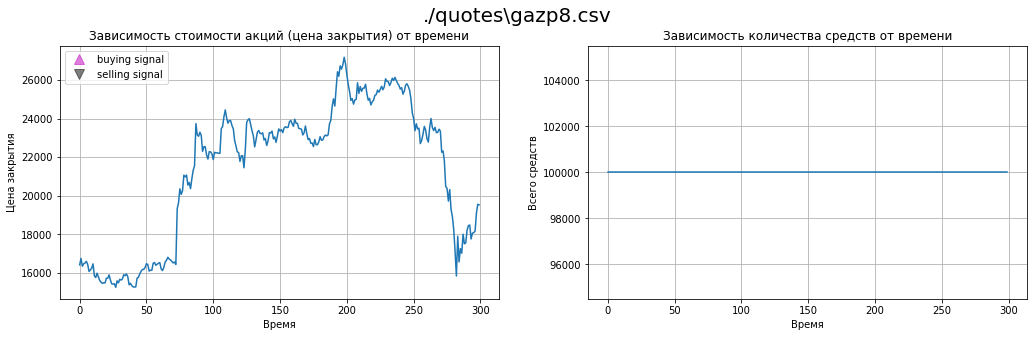

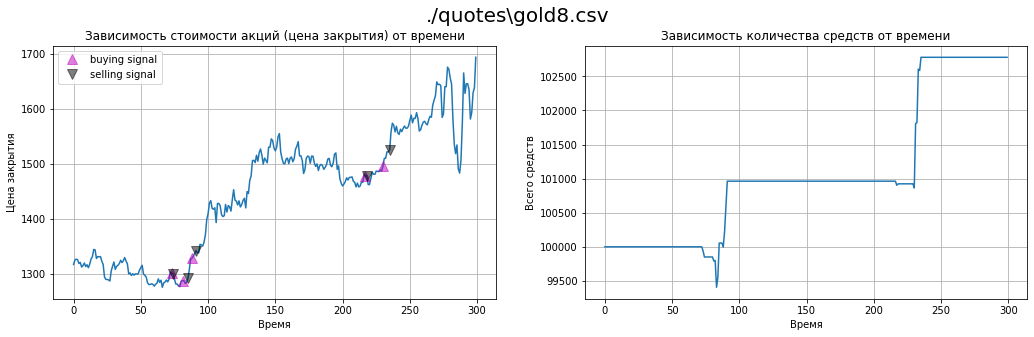

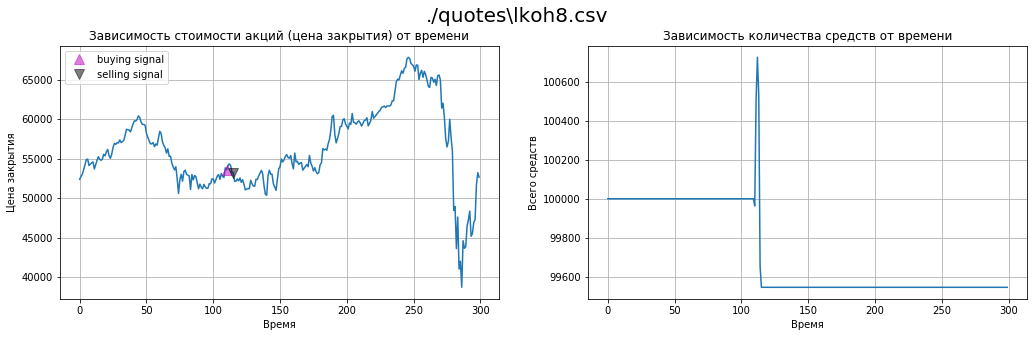

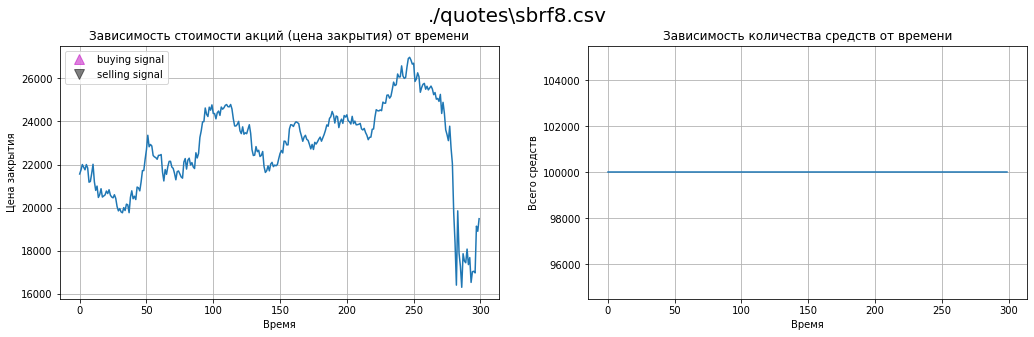

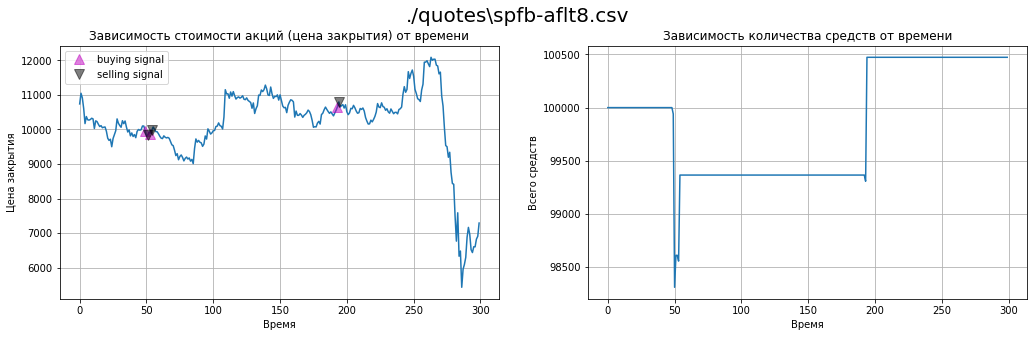

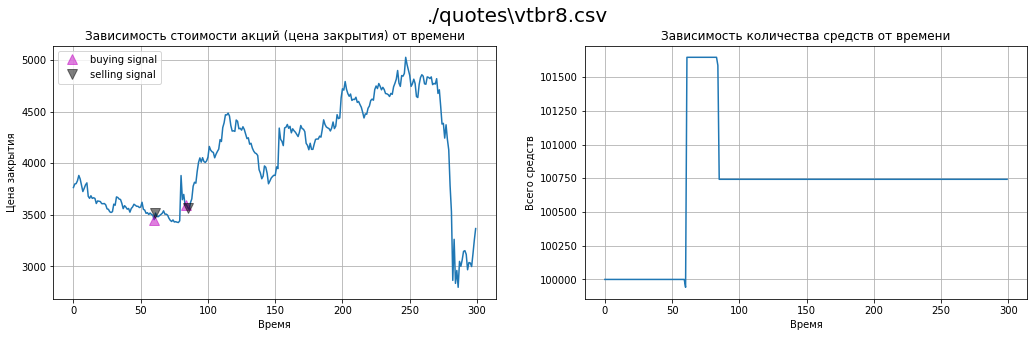

In [57]:
for p in days_dirs:
    automated_test(p, p, cut=300)

## Тест на данных 1H

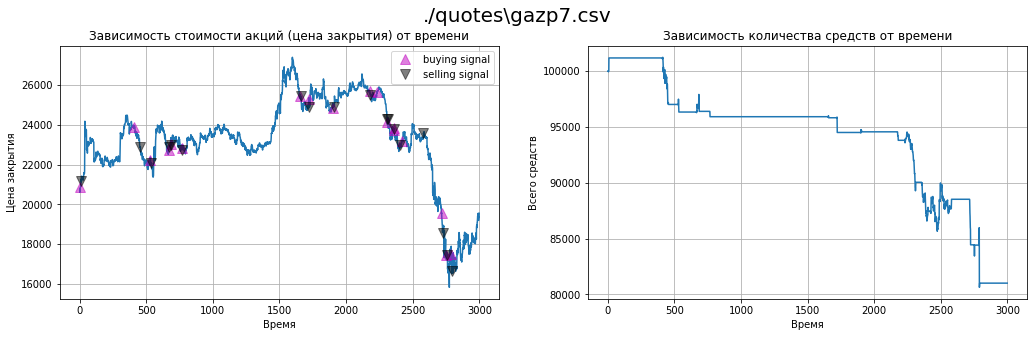

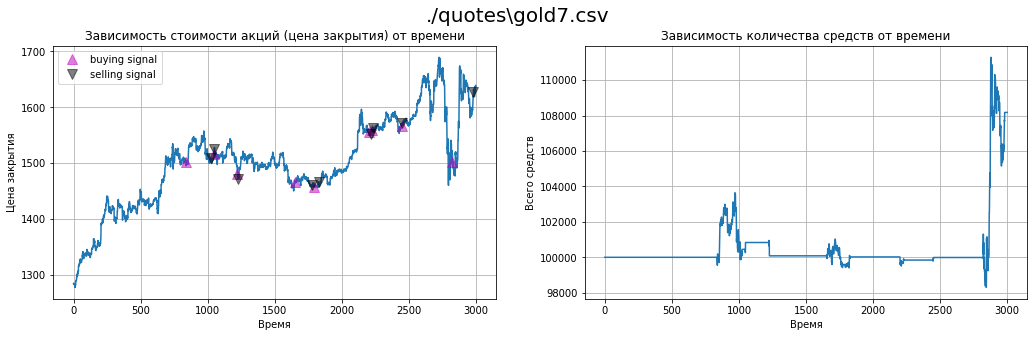

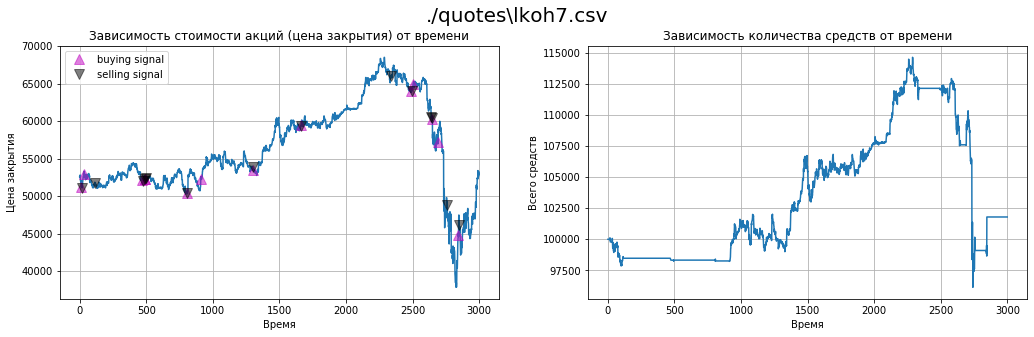

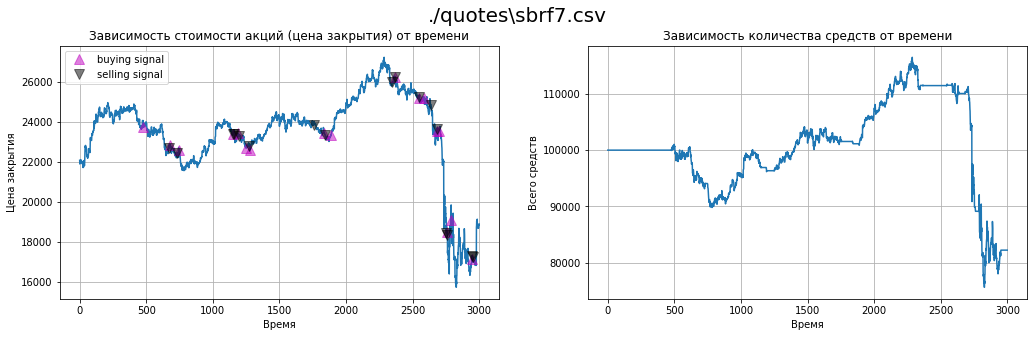

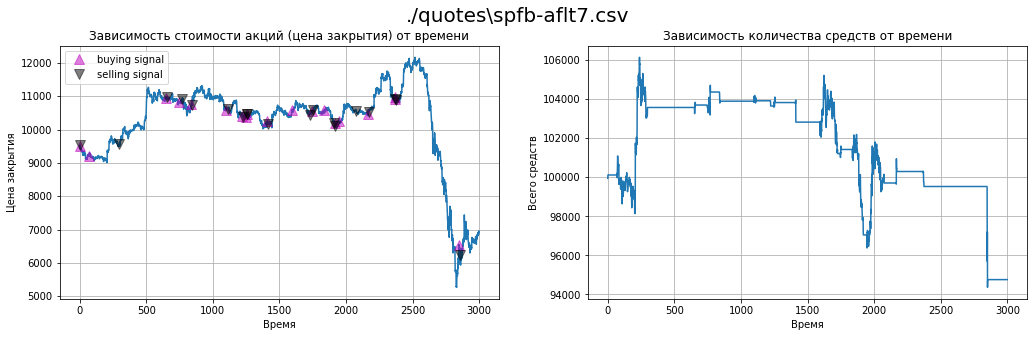

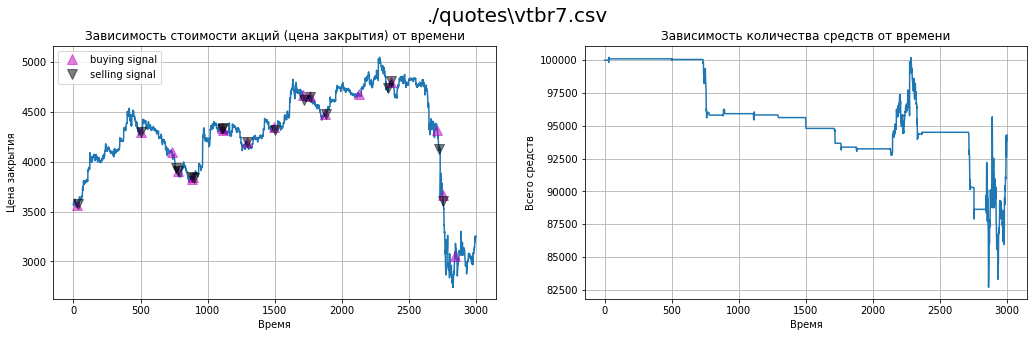

In [61]:
TRAIN_TEST_SPLIT = 0.0
SURE = 0.2
fname = "./models/days.h5"
model = tf.keras.models.load_model(fname)
for p in hours_dirs:
    automated_test(p, p, cut=3000)

## Тест на данных 10М

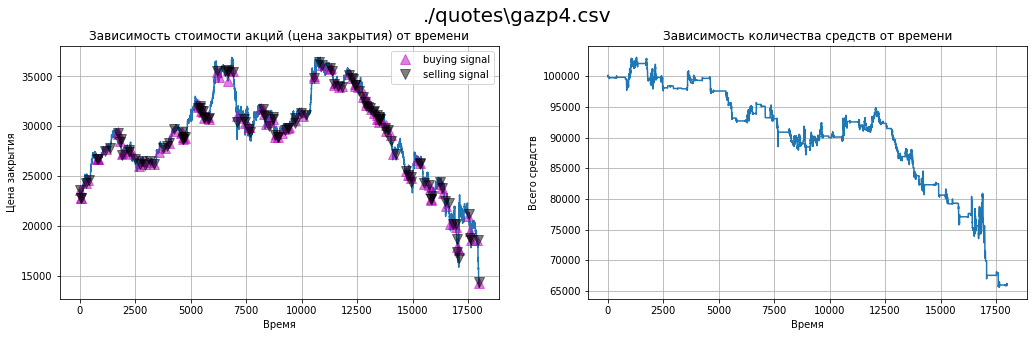

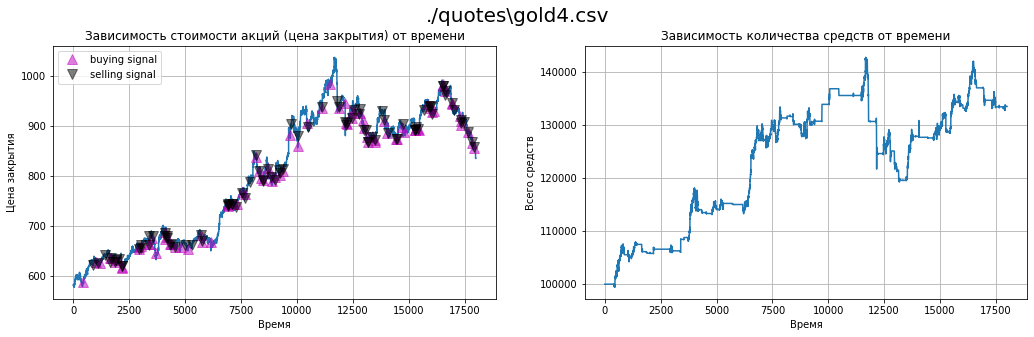

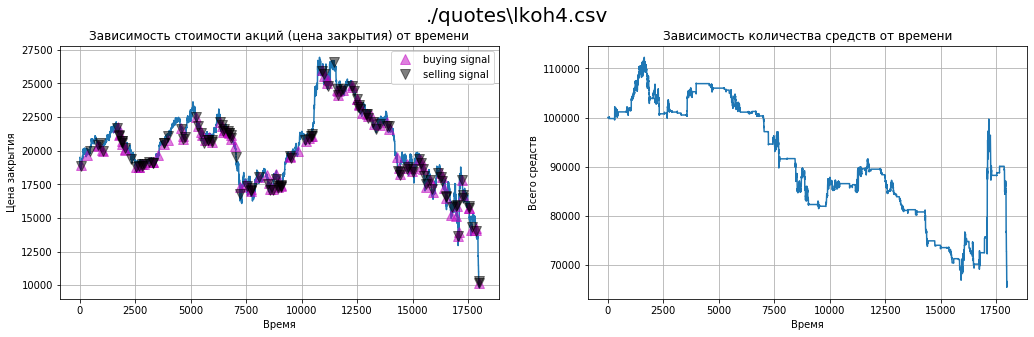

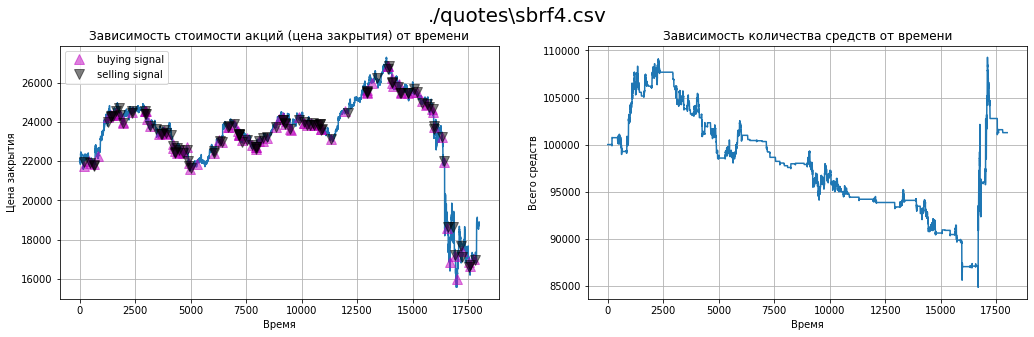

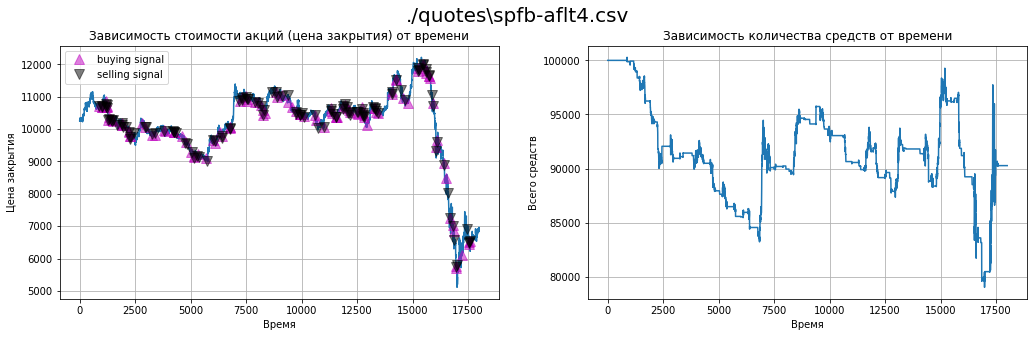

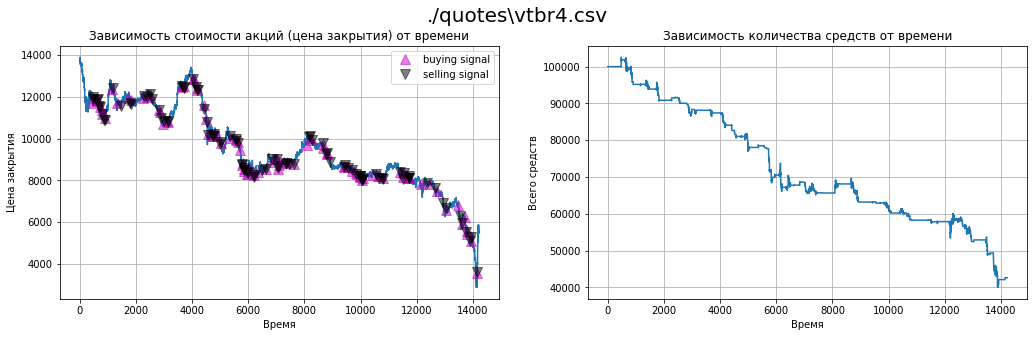

In [66]:
TRAIN_TEST_SPLIT = 0.0
SURE = 0.2
for p in minutes_dirs:
    automated_test(p, p, cut=18000)

# Модель на 1H
## Тест на 1D

In [67]:
fname = "./models/hours.h5"
model = tf.keras.models.load_model(fname)

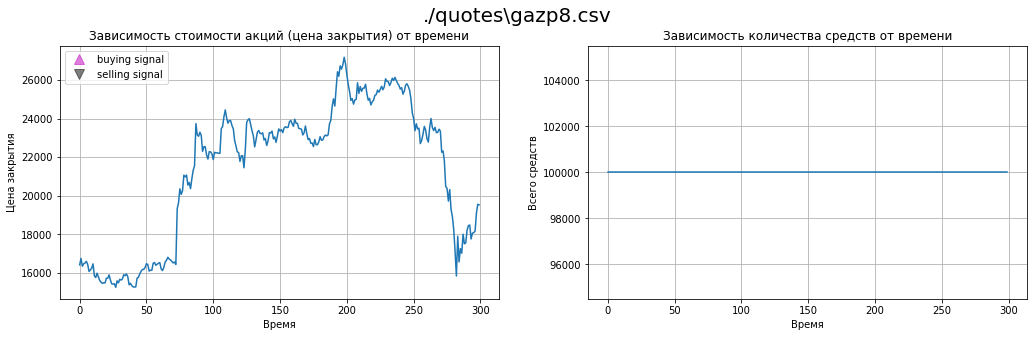

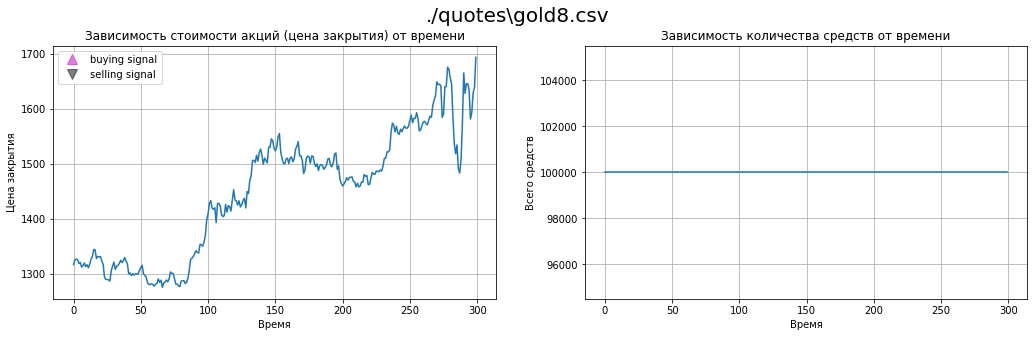

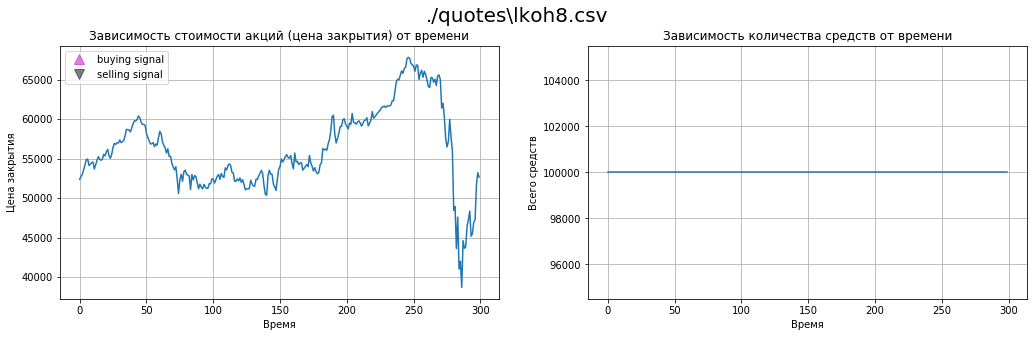

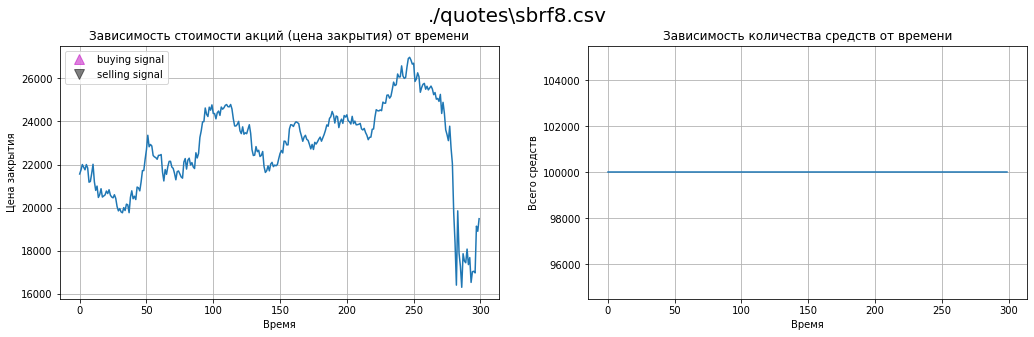

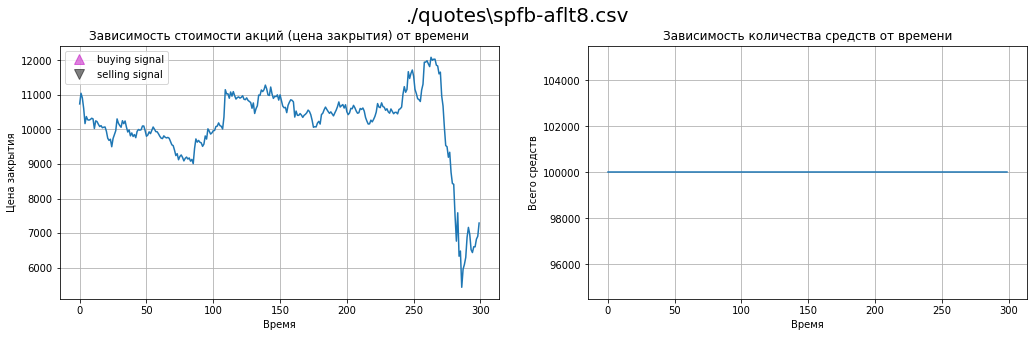

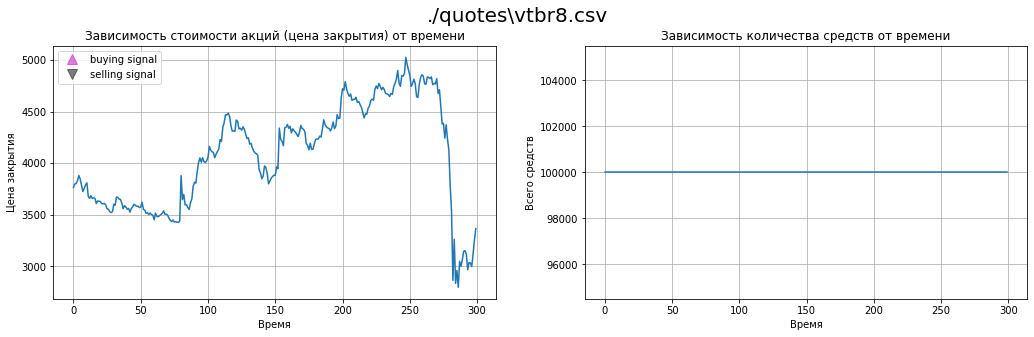

In [68]:
TRAIN_TEST_SPLIT = 0.0
SURE = 0.2
for p in days_dirs:
    automated_test(p, p, cut=300)

## Тест на 1Н

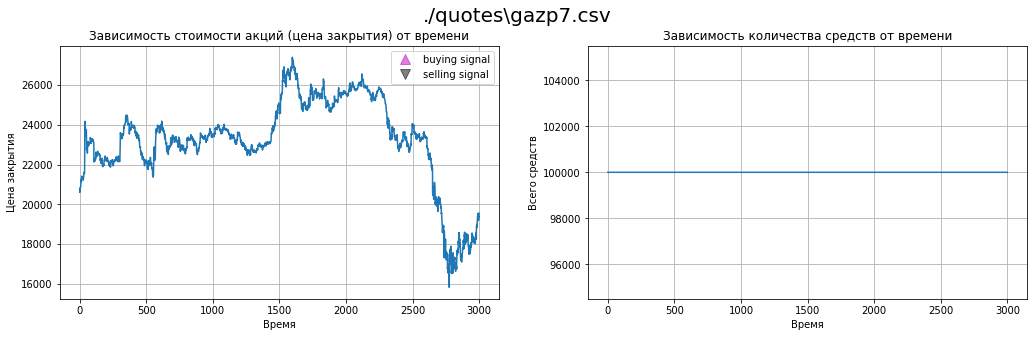

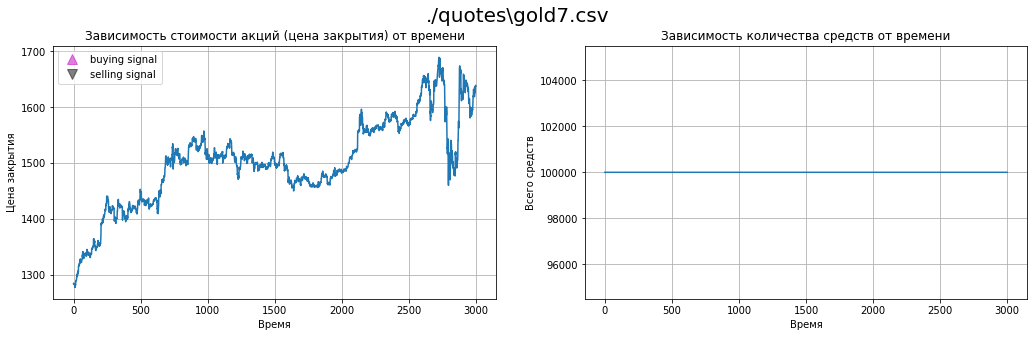

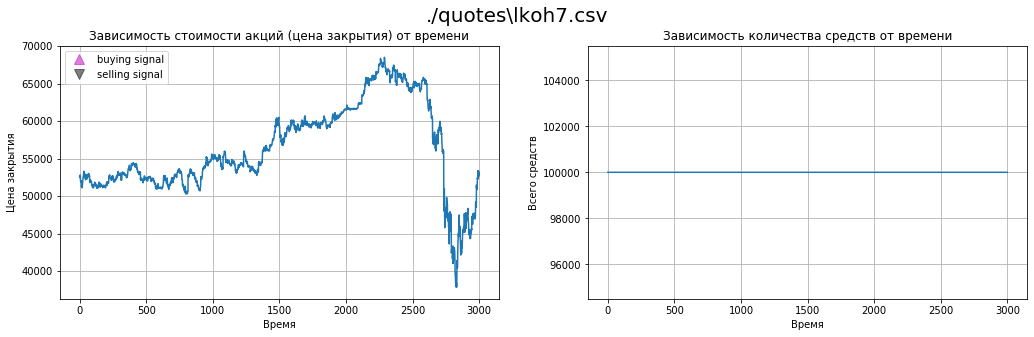

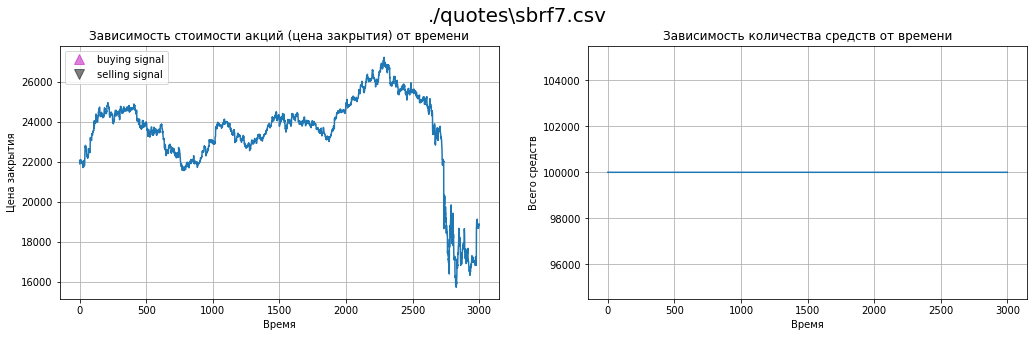

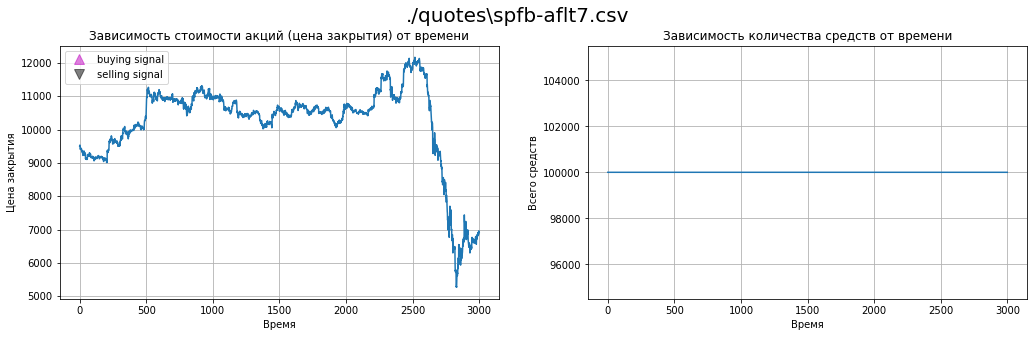

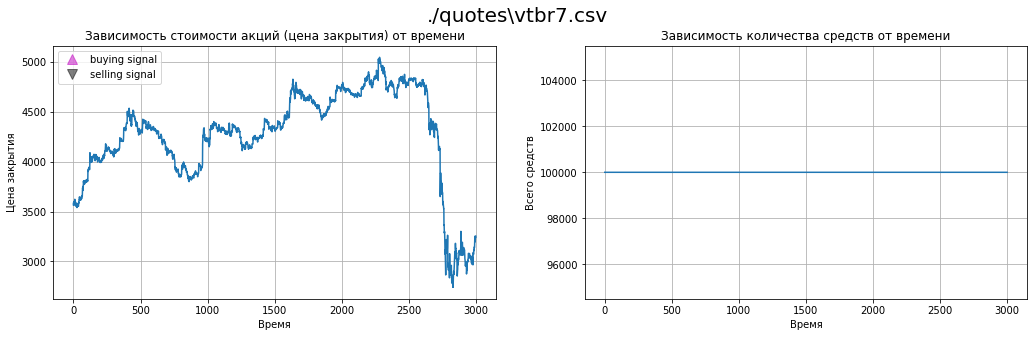

In [69]:
TRAIN_TEST_SPLIT = 0.0
SURE = 0.2
for p in hours_dirs:
    automated_test(p, p, cut=3000)

## Тест на 10М

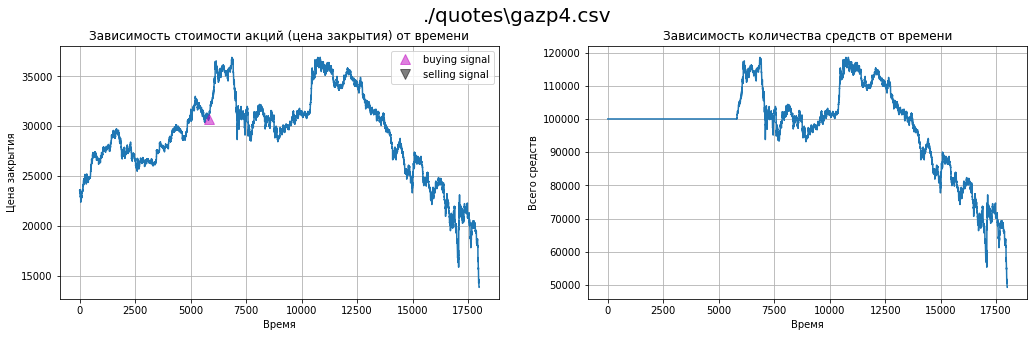

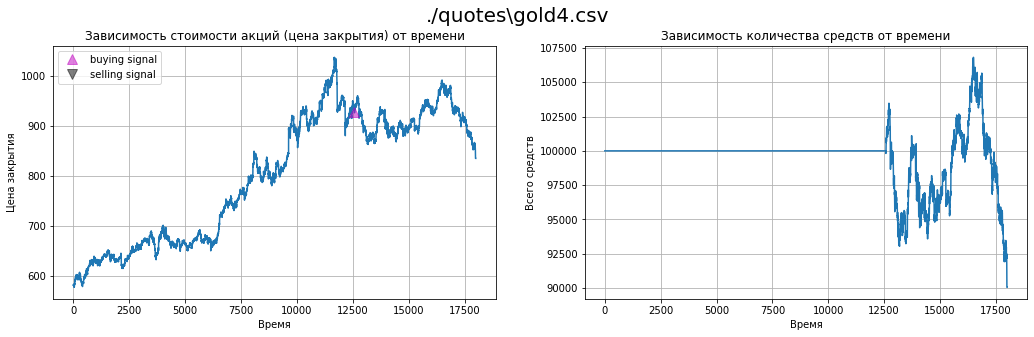

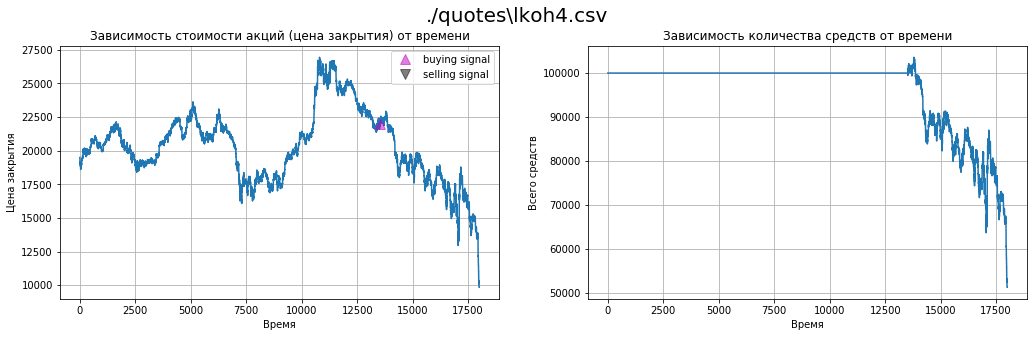

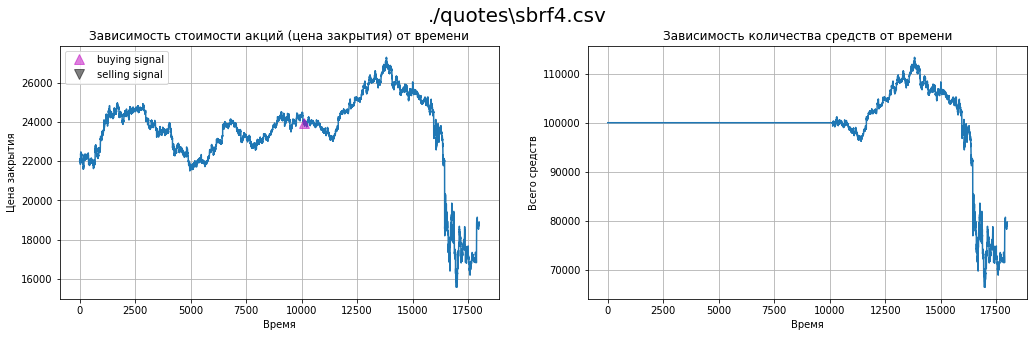

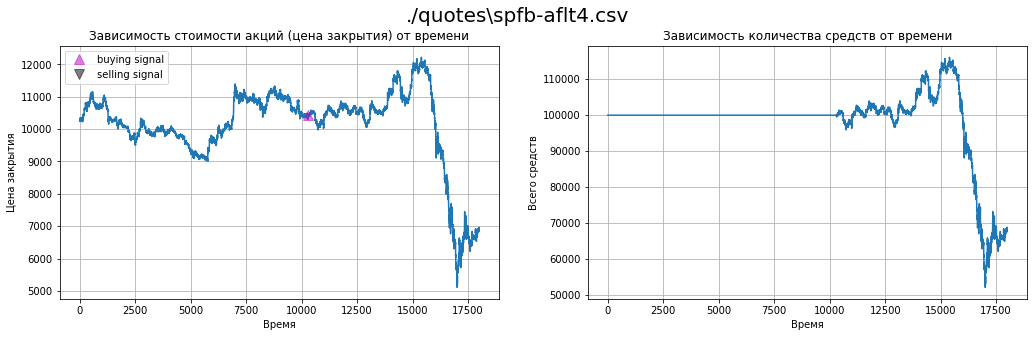

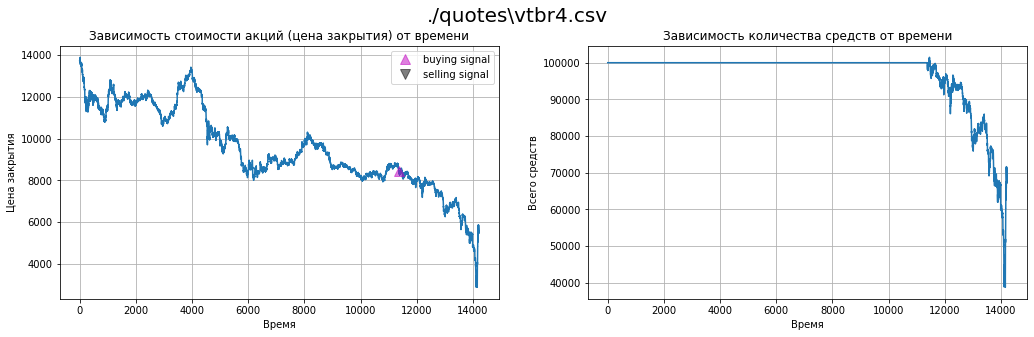

In [70]:
TRAIN_TEST_SPLIT = 0.0
SURE = 0.2
for p in minutes_dirs:
    automated_test(p, p, cut=18000)

# Модель на 10М

In [71]:
fname = "./models/hours.h5"
model = tf.keras.models.load_model(fname)

## Тест на 1D

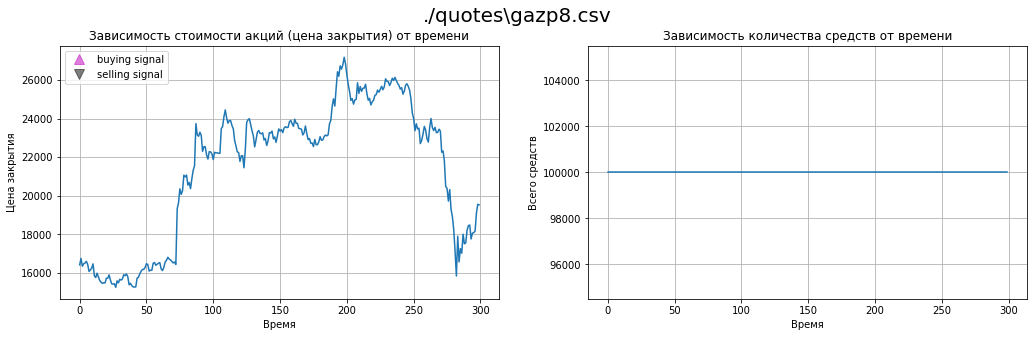

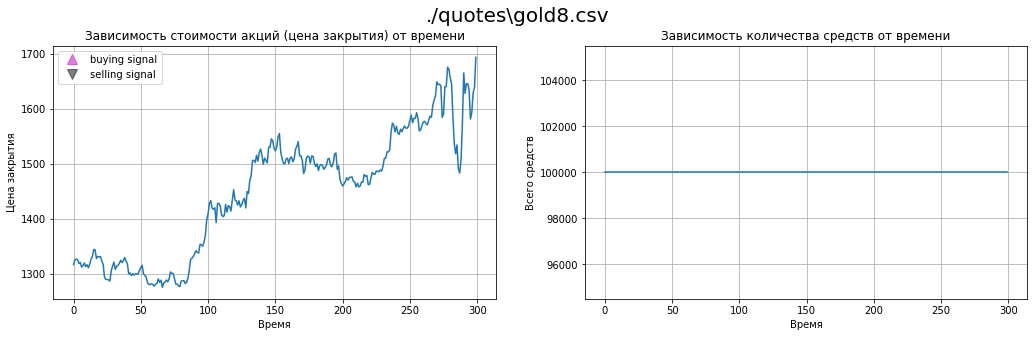

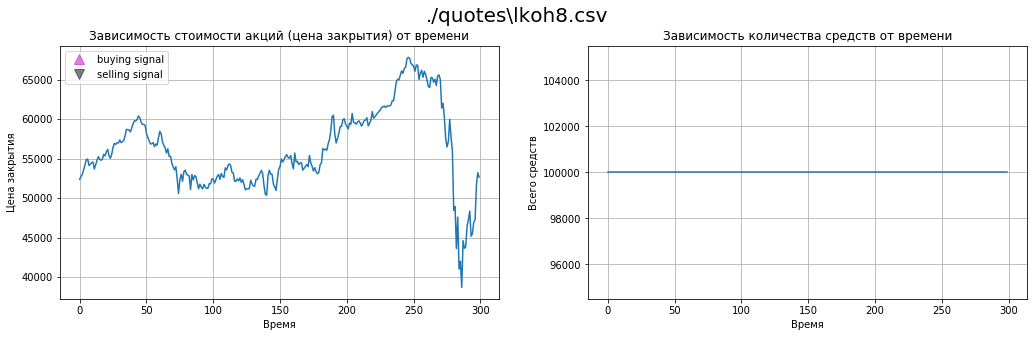

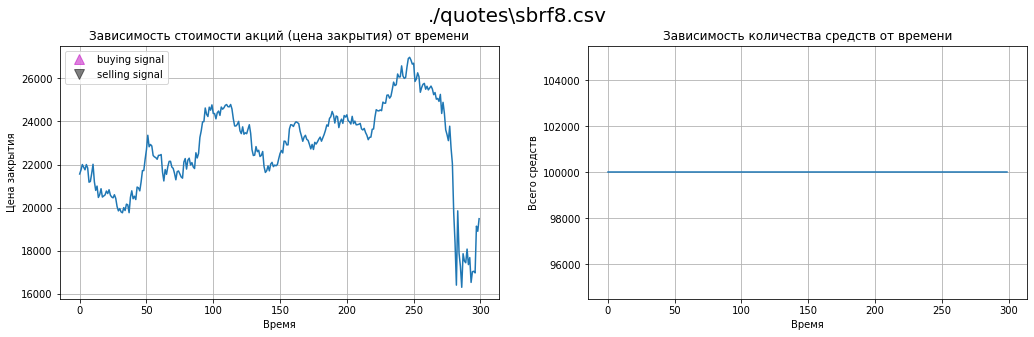

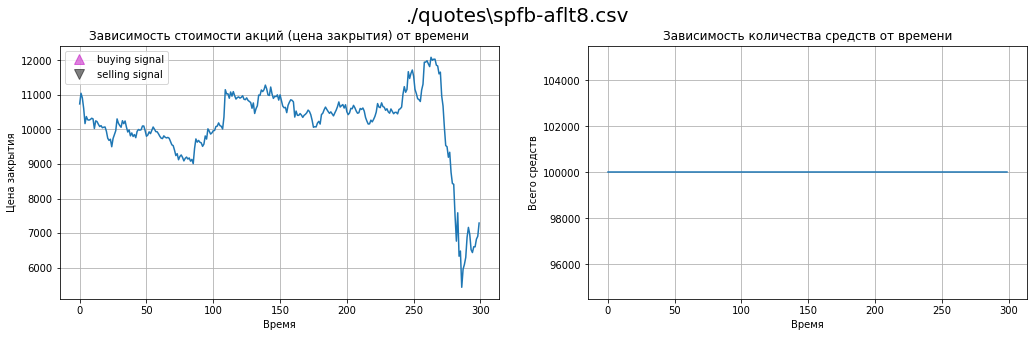

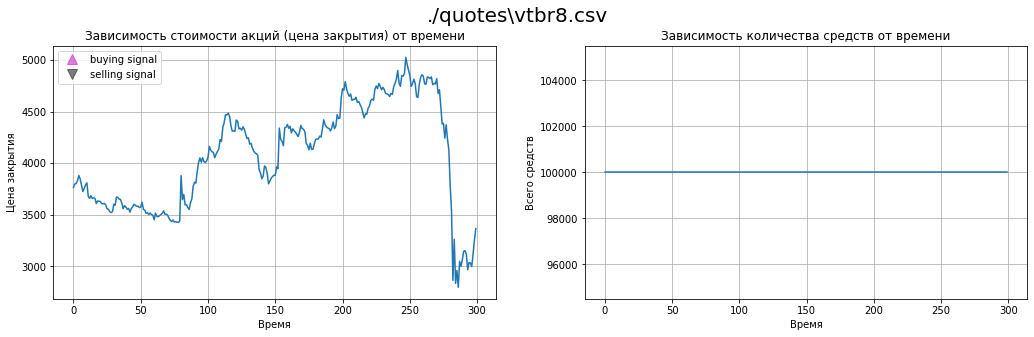

In [73]:
TRAIN_TEST_SPLIT = 0.0
SURE = 0.2
for p in days_dirs:
    automated_test(p, p, cut=300)

## Тест на 1H

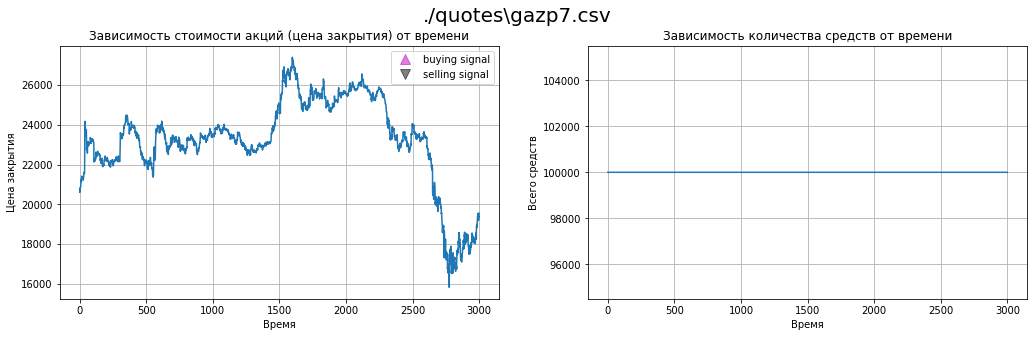

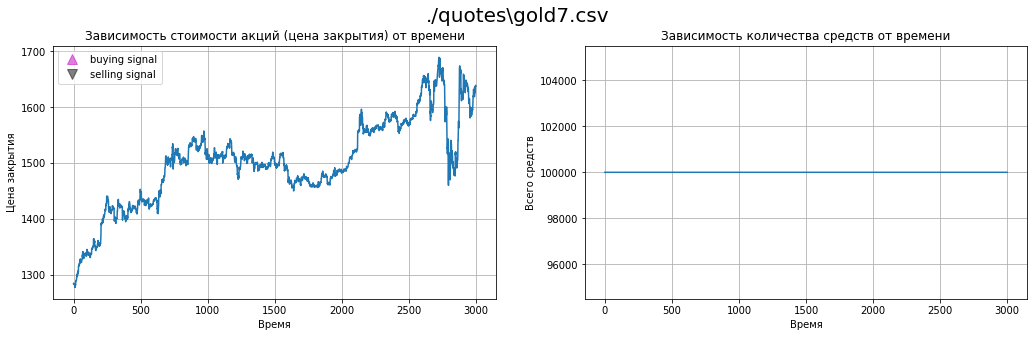

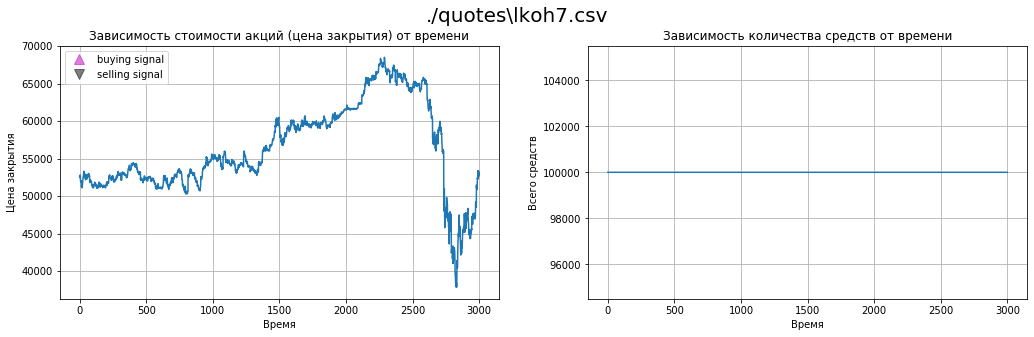

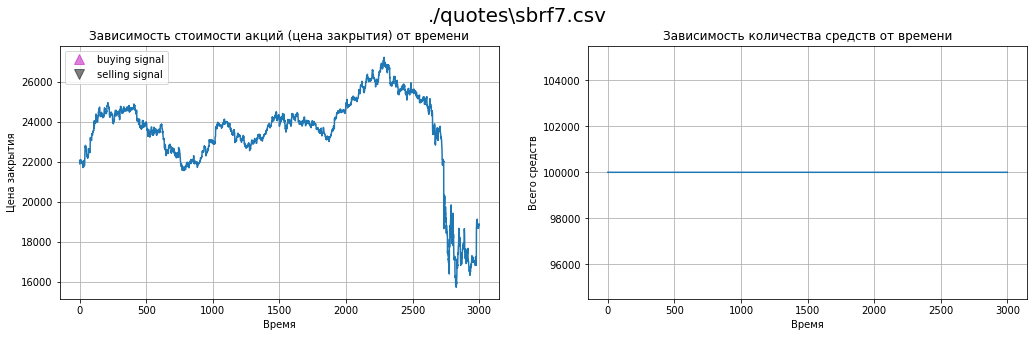

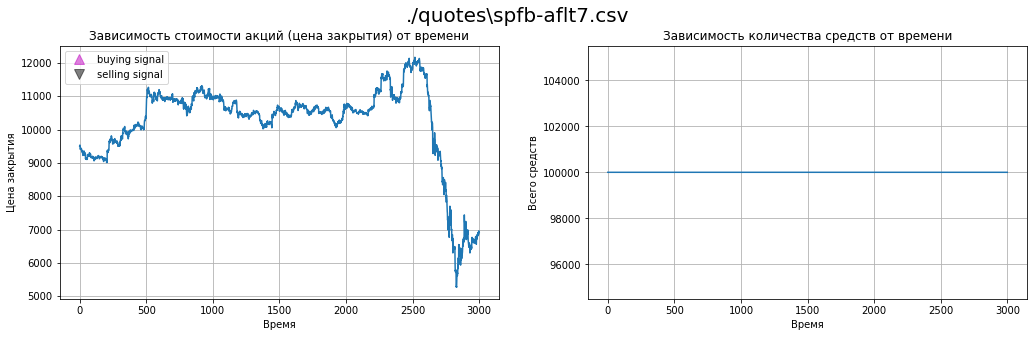

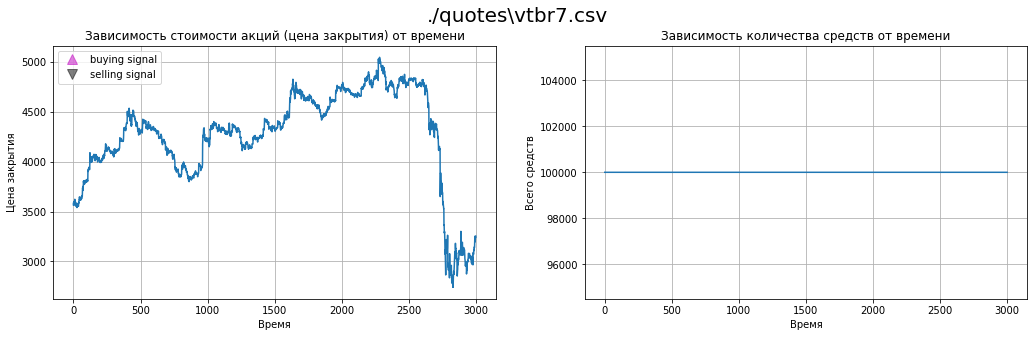

In [74]:
TRAIN_TEST_SPLIT = 0.0
SURE = 0.2
for p in hours_dirs:
    automated_test(p, p, cut=3000)

## Тест на 10M

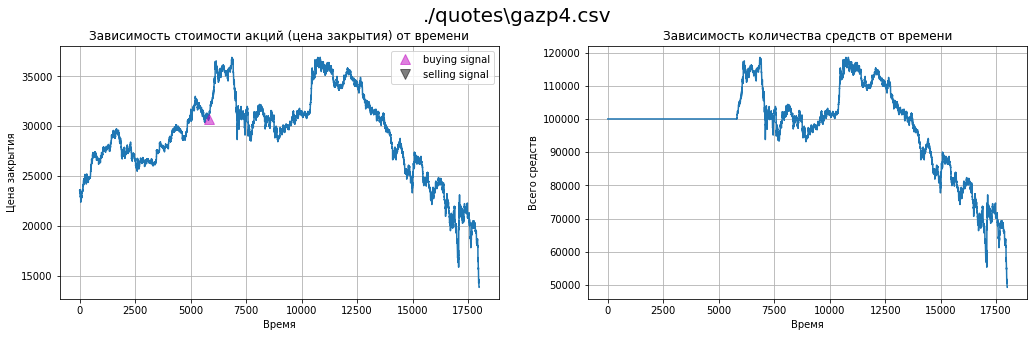

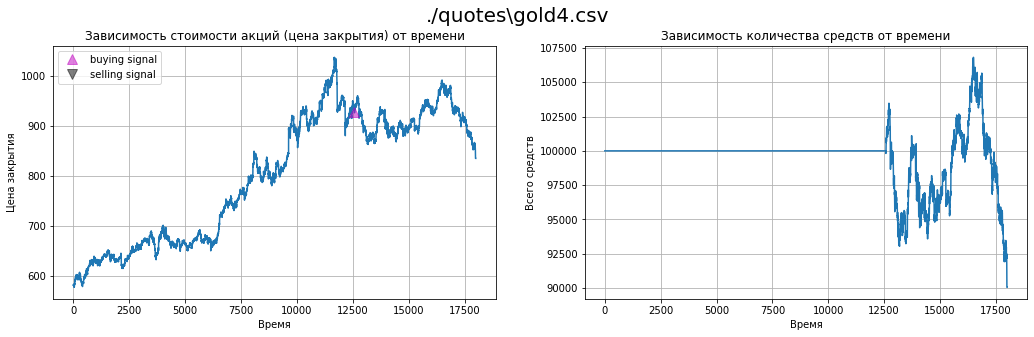

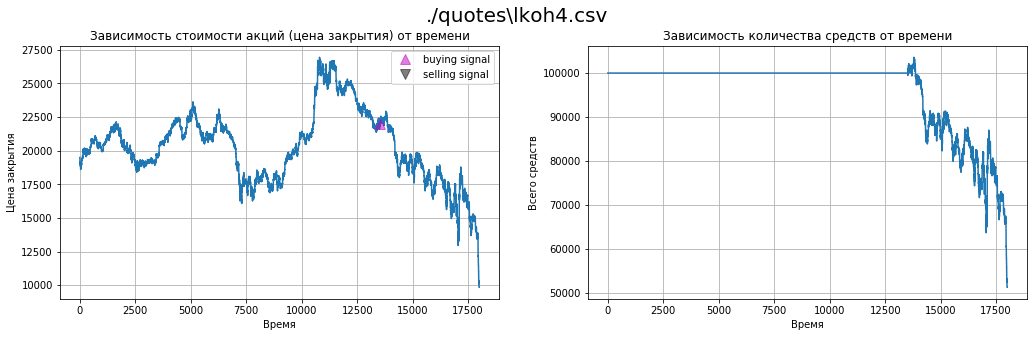

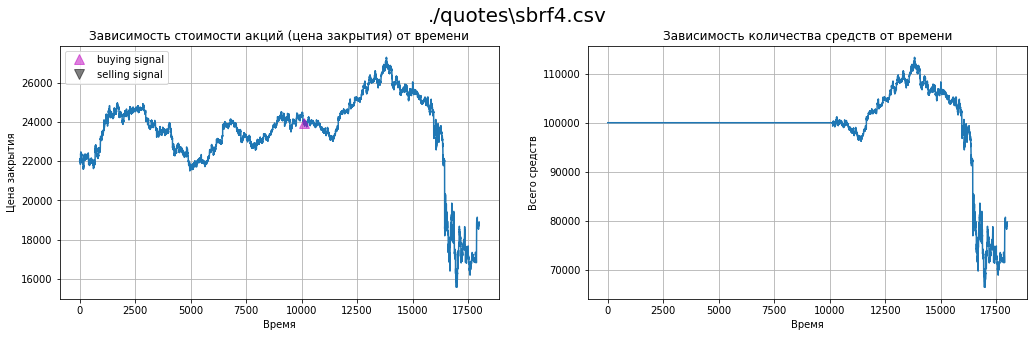

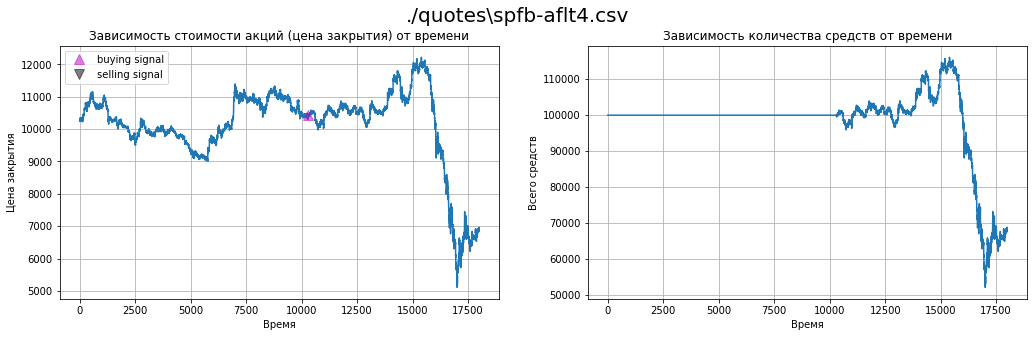

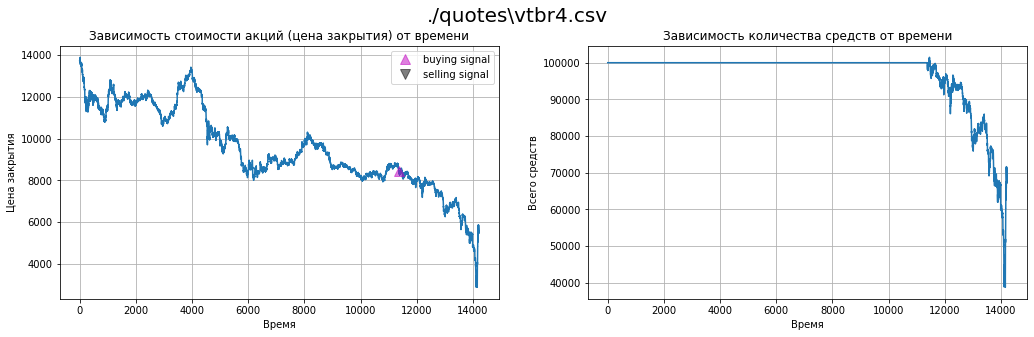

In [75]:
TRAIN_TEST_SPLIT = 0.0
SURE = 0.2
for p in minutes_dirs:
    automated_test(p, p, cut=18000)

In [81]:
dfcopy[:10], signals_test[:10]

(array([17437., 17354., 17402., 17466., 17513., 17408., 17330., 17137.,
        17176., 17347.]), array([1, 0, 1, 1, 1, 0, 0, 0, 1, 1]))

In [84]:
model.predict(data_test[:10])

array([[0.44126007],
       [0.47033828],
       [0.43577462],
       [0.481837  ],
       [0.463349  ],
       [0.47738373],
       [0.4716775 ],
       [0.4712546 ],
       [0.473778  ],
       [0.47510442]], dtype=float32)